In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

<h4>XGBoost</h4>
https://xgboost.readthedocs.io/en/latest/ <br>
https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=api#module-xgboost.sklearn <br>
https://www.lfd.uci.edu/~gohlke/pythonlibs <br>

In [4]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [5]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

<h4>학습데이터 로드</h4>

In [6]:
ls "./DACON"

 C 드라이브의 볼륨: SSD
 볼륨 일련 번호: BCA4-98AF

 C:\Users\inhoinno\DACON 디렉터리

2020-09-25  오전 11:22    <DIR>          .
2020-09-25  오전 11:22    <DIR>          ..
2020-09-10  오후 12:55                43 .gitattributes
2020-09-25  오전 10:56    <DIR>          .ipynb_checkpoints
2020-09-19  오후 08:17        11,060,442 EDA_train_Inhoinno(ing).ipynb
2020-09-10  오후 12:42       132,988,145 feature.csv
2020-09-25  오전 10:59       129,839,372 feature_train_file.csv
2020-09-25  오전 11:22         3,058,689 pandas_inhodemo.ipynb
2020-09-10  오후 12:36         2,897,812 pandasdemo.ipynb
2020-09-10  오후 12:42           800,010 sample_submission.csv
2020-09-10  오후 12:42        18,936,246 test.csv
2020-09-10  오후 12:42        76,278,443 train.csv
2020-09-10  오후 12:37    <DIR>          단국대천체모형
               9개 파일         375,859,202 바이트
               4개 디렉터리  80,511,782,912 바이트 남음


In [7]:
data_dir = Path('./DACON')
trn_file = data_dir / 'feature_train_file.csv'
tst_file = data_dir / 'test.csv'
feature_file = data_dir / 'feature.csv'
submission = pd.read_csv("./sample_submission.csv")
seed = 42


<h4> Train/Test 데이터 분석하기 </h4>

In [8]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)
feature= pd.concat([train,test], axis =0)

print(train.info())
print(test.info())
print(train.shape)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320000 entries, 0 to 319999
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            320000 non-null  int64  
 1   u             320000 non-null  float64
 2   g             320000 non-null  float64
 3   r             320000 non-null  float64
 4   i             320000 non-null  float64
 5   z             320000 non-null  float64
 6   redshift      320000 non-null  float64
 7   dered_u       320000 non-null  float64
 8   dered_g       320000 non-null  float64
 9   dered_r       320000 non-null  float64
 10  dered_i       320000 non-null  float64
 11  dered_z       320000 non-null  float64
 12  airmass_u     320000 non-null  float64
 13  class         320000 non-null  int64  
 14  nObserve_log  320000 non-null  float64
 15  nDetect_log   320000 non-null  float64
 16  d_dered_u     320000 non-null  float64
 17  d_dered_g     320000 non-null  float64
 18  d_de

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,class,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
0,0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,1.1898,0,2.9444,2.9444,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,0
1,1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1.2533,1,0.6931,0.6931,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,0
2,2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0225,0,1.0986,1.0986,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,0
3,3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.2054,0,1.6094,1.3863,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,1
4,4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,1.1939,0,2.6391,2.5649,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,1


In [7]:
test.head()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z
0,320000,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1,1,1.1563,1.1515,1.1613,1.1588,1.1539
1,320001,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,2,2,1.0076,1.0074,1.0080,1.0078,1.0075
2,320002,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1,1,1.3809,1.3905,1.3715,1.3761,1.3856
3,320003,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1,1,1.1408,1.1408,1.1409,1.1408,1.1408
4,320004,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,2,2,1.1110,1.1077,1.1145,1.1127,1.1093


In [9]:
df = test
df['d_dered_u'] = df['dered_u'] - df['u']
df['d_dered_g'] = df['dered_g'] - df['g']
df['d_dered_r'] = df['dered_r'] - df['r']
df['d_dered_i'] = df['dered_i'] - df['i']
df['d_dered_z'] = df['dered_z'] - df['z']
df['d_dered_rg'] = df['dered_r'] - df['dered_g']
df['d_dered_ig'] = df['dered_i'] - df['dered_g']
df['d_dered_zg'] = df['dered_z'] - df['dered_g']
df['d_dered_ri'] = df['dered_r'] - df['dered_i']
df['d_dered_rz'] = df['dered_r'] - df['dered_z']
df['d_dered_iz'] = df['dered_i'] - df['dered_z']
df['d_obs_det'] = df['nObserve'] - df['nDetect']
print(df.shape)
df.describe()

(80000, 31)


,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det
count,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,8.0000e+04,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000
mean,359999.5000,19.8598,18.4371,17.7397,17.3065,17.1490,6.0083e-02,19.6350,18.2638,17.6193,17.2178,16.8702,6.3499,6.1578,1.1760,1.1767,1.1753,1.1756,1.1763,-0.2249,-0.1733,-0.1204,-0.0887,-0.2787,-0.6444,-1.0460,-1.3935,0.4015,0.7491,0.3476,0.1922
std,23094.1551,1.9543,1.7030,1.4786,1.3207,24.6431,3.4684e-01,1.9210,1.6657,1.4760,1.3324,35.4367,8.8728,8.5509,0.1164,0.1182,0.1148,0.1156,0.1173,0.7107,0.6235,0.3967,0.2865,60.0184,0.5555,0.8945,35.4120,0.5405,35.4029,35.3975,1.0084
min,320000.0000,-0.3385,-51.1753,-5.4387,5.3267,-39.5272,-3.0149e+01,-30.6337,-18.6560,-8.7560,-3.6973,-9999.0000,1.0000,1.0000,1.0001,1.0001,1.0002,1.0002,1.0001,-54.8323,-69.3194,-29.3532,-21.8010,-16975.3922,-13.0229,-13.4431,-10012.3326,-11.5039,-12.6504,-12.4170,-1.0000
25%,339999.7500,18.7273,17.4780,16.8820,16.5255,16.2882,3.3645e-05,18.5709,17.3522,16.7906,16.4562,16.2310,1.0000,1.0000,1.0881,1.0883,1.0877,1.0879,1.0882,-0.2340,-0.1650,-0.1138,-0.0847,-0.0700,-0.8136,-1.2357,-1.5288,0.2149,0.3083,0.0849,0.0000
50%,359999.5000,19.4261,18.1451,17.5299,17.1560,16.9212,4.7115e-02,19.2674,18.0247,17.4487,17.0912,16.8733,2.0000,2.0000,1.1794,1.1793,1.1794,1.1794,1.1793,-0.1343,-0.1017,-0.0704,-0.0523,-0.0406,-0.5848,-0.9203,-1.1220,0.3388,0.5365,0.2023,0.0000
75%,379999.2500,20.4344,19.0793,18.4345,18.0080,17.7333,9.4769e-02,20.1999,18.8948,18.2952,17.9109,17.6578,5.0000,5.0000,1.2278,1.2262,1.2294,1.2289,1.2269,-0.0709,-0.0634,-0.0441,-0.0326,-0.0210,-0.3828,-0.6030,-0.6987,0.4273,0.7159,0.2968,0.0000
max,399999.0000,56.8471,94.3591,46.6913,33.0259,6976.3922,4.6390e+01,30.8899,30.9529,31.6536,30.9478,28.6441,44.0000,42.0000,2.0502,2.0797,2.0216,2.0358,2.0648,25.6354,76.1173,30.1964,18.9817,62.2878,14.8045,14.9587,18.8719,14.2138,10011.6575,10011.3000,37.0000


In [10]:
df.drop(['airmass_z', 'airmass_i', 'airmass_r', 'airmass_g', 'd_dered_rg', 'd_dered_ri'], 
        axis=1, inplace=True)
print(df.shape)
df.head()

(80000, 25)


,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
0,320000,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1,1,1.1563,-0.0681,-0.0622,-0.0424,-0.0306,-0.0176,-0.8711,-1.0462,0.5221,0.1751,0
1,320001,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,2,2,1.0076,-3.6706,-2.8607,-1.9790,-1.4705,-1.0935,0.2062,0.3274,-0.2470,-0.1212,0
2,320002,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1,1,1.3809,-0.1977,-0.1077,-0.0761,-0.0599,-0.0664,-1.0230,-1.2037,0.5771,0.1808,0
3,320003,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1,1,1.1408,-0.1045,-0.0834,-0.0572,-0.0418,-0.0288,-0.3036,-0.3068,0.0802,0.0032,0
4,320004,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,2,2,1.1110,-0.0780,-0.0852,-0.0572,-0.0407,-0.0187,-0.8480,-1.0361,0.5129,0.1881,0


In [11]:
df['nObserve_log'] = df['nObserve'].apply(np.log1p)
df['nDetect_log'] = df['nDetect'].apply(np.log1p)

In [12]:
test= df

<h4> Train, Test 를 보면 train[g,i,z,dered_g, dered_i,dered_z] 가 Outlier가 있는걸 알수 있음 </h4>

In [13]:
train.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,class,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
count,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,3.2000e+05,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000
mean,159999.5000,19.8524,18.3768,17.7358,17.1742,16.8752,5.8308e-02,19.6289,18.2271,17.6154,17.1523,16.8693,1.1758,1.1163,1.4861,1.4702,-0.2236,-0.1498,-0.1203,-0.0219,-0.0059,-1.0747,-1.3578,0.7462,0.2831,0.1939
std,92376.1874,1.9455,31.1108,1.4662,52.5615,57.1463,5.7546e-01,1.9236,17.7866,1.4730,25.0758,35.4365,0.1163,0.9235,0.9061,0.8959,0.6967,13.3675,0.3630,28.0581,28.2757,17.7284,30.6874,35.4207,25.0444,1.0243
min,0.0000,-17.6875,-17555.3656,7.7314,-23955.8178,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0001,0.0000,0.6931,0.6931,-66.3661,-51.2796,-46.9576,-26.3505,-1968.6898,-10017.1270,-10017.2590,-17.7428,-16.6637,-1.0000
25%,79999.7500,18.7242,17.4749,16.8772,16.5239,16.2889,3.5580e-05,18.5636,17.3484,16.7871,16.4530,16.2341,1.0882,0.0000,0.6931,0.6931,-0.2342,-0.1649,-0.1136,-0.0847,-0.0700,-1.2330,-1.5263,0.3072,0.0844,0.0000
50%,159999.5000,19.4194,18.1405,17.5258,17.1497,16.9176,4.7129e-02,19.2646,18.0224,17.4434,17.0874,16.8694,1.1793,1.0000,1.0986,1.0986,-0.1342,-0.1014,-0.0701,-0.0523,-0.0405,-0.9160,-1.1169,0.5338,0.2009,0.0000
75%,239999.2500,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8884,18.2911,17.9070,17.6557,1.2275,2.0000,1.7918,1.7918,-0.0706,-0.0632,-0.0439,-0.0325,-0.0207,-0.6014,-0.6951,0.7146,0.2965,0.0000
max,319999.0000,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,2.0508,2.0000,3.8067,3.7612,42.2511,7556.3656,16.9807,13956.8178,13956.8178,21.8604,27.7746,10016.8755,10016.5565,40.0000


In [14]:
test.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det,nObserve_log,nDetect_log
count,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,8.0000e+04,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000,80000.0000
mean,359999.5000,19.8598,18.4371,17.7397,17.3065,17.1490,6.0083e-02,19.6350,18.2638,17.6193,17.2178,16.8702,6.3499,6.1578,1.1760,-0.2249,-0.1733,-0.1204,-0.0887,-0.2787,-1.0460,-1.3935,0.7491,0.3476,0.1922,1.4903,1.4743
std,23094.1551,1.9543,1.7030,1.4786,1.3207,24.6431,3.4684e-01,1.9210,1.6657,1.4760,1.3324,35.4367,8.8728,8.5509,0.1164,0.7107,0.6235,0.3967,0.2865,60.0184,0.8945,35.4120,35.4029,35.3975,1.0084,0.9055,0.8956
min,320000.0000,-0.3385,-51.1753,-5.4387,5.3267,-39.5272,-3.0149e+01,-30.6337,-18.6560,-8.7560,-3.6973,-9999.0000,1.0000,1.0000,1.0001,-54.8323,-69.3194,-29.3532,-21.8010,-16975.3922,-13.4431,-10012.3326,-12.6504,-12.4170,-1.0000,0.6931,0.6931
25%,339999.7500,18.7273,17.4780,16.8820,16.5255,16.2882,3.3645e-05,18.5709,17.3522,16.7906,16.4562,16.2310,1.0000,1.0000,1.0881,-0.2340,-0.1650,-0.1138,-0.0847,-0.0700,-1.2357,-1.5288,0.3083,0.0849,0.0000,0.6931,0.6931
50%,359999.5000,19.4261,18.1451,17.5299,17.1560,16.9212,4.7115e-02,19.2674,18.0247,17.4487,17.0912,16.8733,2.0000,2.0000,1.1794,-0.1343,-0.1017,-0.0704,-0.0523,-0.0406,-0.9203,-1.1220,0.5365,0.2023,0.0000,1.0986,1.0986
75%,379999.2500,20.4344,19.0793,18.4345,18.0080,17.7333,9.4769e-02,20.1999,18.8948,18.2952,17.9109,17.6578,5.0000,5.0000,1.2278,-0.0709,-0.0634,-0.0441,-0.0326,-0.0210,-0.6030,-0.6987,0.7159,0.2968,0.0000,1.7918,1.7918
max,399999.0000,56.8471,94.3591,46.6913,33.0259,6976.3922,4.6390e+01,30.8899,30.9529,31.6536,30.9478,28.6441,44.0000,42.0000,2.0502,25.6354,76.1173,30.1964,18.9817,62.2878,14.9587,18.8719,10011.6575,10011.3000,37.0000,3.8067,3.7612


<h4> 테스트 데이터의 경우 test[g,z,dered_z] 정도가 좀 불편함 </h4>
--> 겹치는 field는 g, z, dered_z 임

In [15]:
train[(train['class'] == 2)].describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,class,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
count,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000,157219.0000
mean,160075.7694,19.2380,17.8746,17.2048,16.6790,16.3225,0.0918,19.0890,17.7590,17.1243,16.7084,16.3531,1.1671,2.0,1.2781,1.2664,-0.1490,-0.1155,-0.0805,0.0294,0.0306,-1.0507,-1.4059,0.7712,0.3553,0.1324
std,92382.9512,1.0715,1.0166,0.9897,60.4673,68.4103,0.0572,1.0298,0.9942,0.9645,25.2785,43.7612,0.1183,0.0,0.7566,0.7460,0.2400,0.1732,0.1771,35.1997,35.5522,25.2636,43.7540,43.7540,35.7249,0.8459
min,5.0000,3.7674,-12.4441,9.8544,-23955.8178,-23955.8178,-0.0008,12.2915,11.9272,11.1424,-9999.0000,-9999.0000,1.0019,2.0,0.6931,0.6931,-23.6245,-21.3197,-46.9576,-13.2341,-1968.6898,-10017.1270,-10017.2590,-10.5090,-11.9804,0.0000
25%,79986.5000,18.7004,17.3863,16.7497,16.3739,16.1151,0.0541,18.5697,17.2813,16.6761,16.3194,16.0736,1.0739,2.0,0.6931,0.6931,-0.1972,-0.1438,-0.0998,-0.0746,-0.0611,-1.1757,-1.4618,0.4686,0.1718,0.0000
50%,160092.0000,19.2525,17.9417,17.2981,16.9181,16.6660,0.0810,19.1208,17.8376,17.2253,16.8635,16.6262,1.1531,2.0,1.0986,1.0986,-0.1235,-0.0935,-0.0648,-0.0484,-0.0375,-0.9925,-1.2269,0.5959,0.2349,0.0000
75%,240184.5000,19.7410,18.3297,17.6502,17.2754,17.0488,0.1171,19.5932,18.2191,17.5765,17.2204,17.0073,1.2204,2.0,1.3863,1.3863,-0.0695,-0.0599,-0.0415,-0.0307,-0.0195,-0.7883,-0.9585,0.6984,0.2898,0.0000
max,319995.0000,47.9278,46.3383,72.0097,36.7897,52.6127,0.5659,30.7779,30.3180,31.8750,32.0162,27.4069,1.8639,2.0,3.7842,3.7377,20.5373,37.5039,14.1958,13956.8178,13956.8178,14.9771,9.8202,10016.8755,10016.5565,35.0000


Box로 보기

Text(0.5, 1.0, 'class vs d_dered_g')

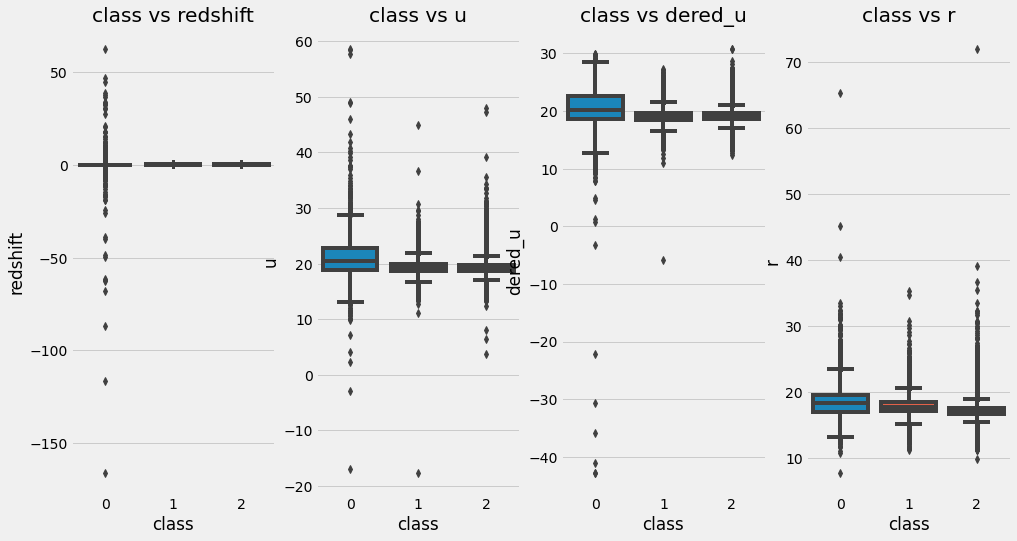

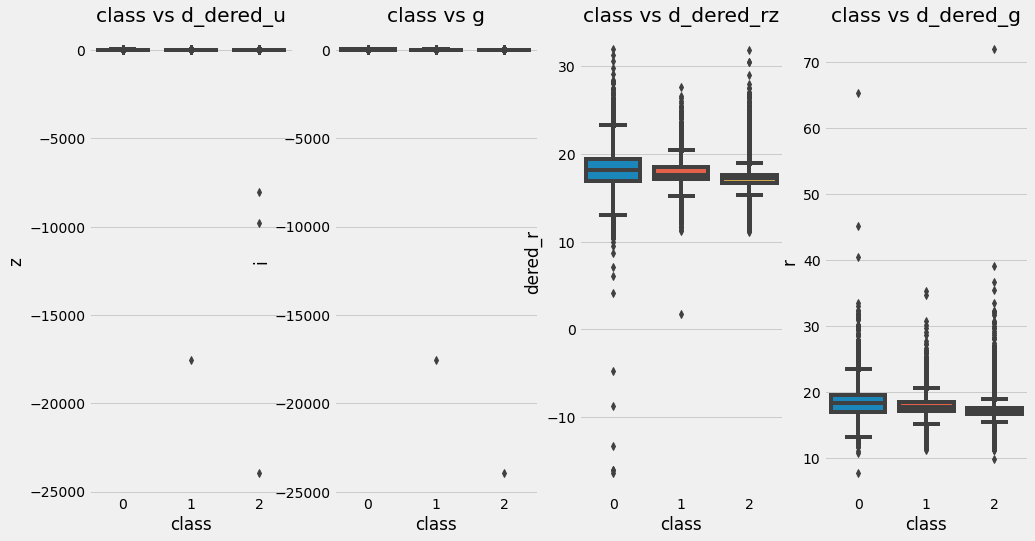

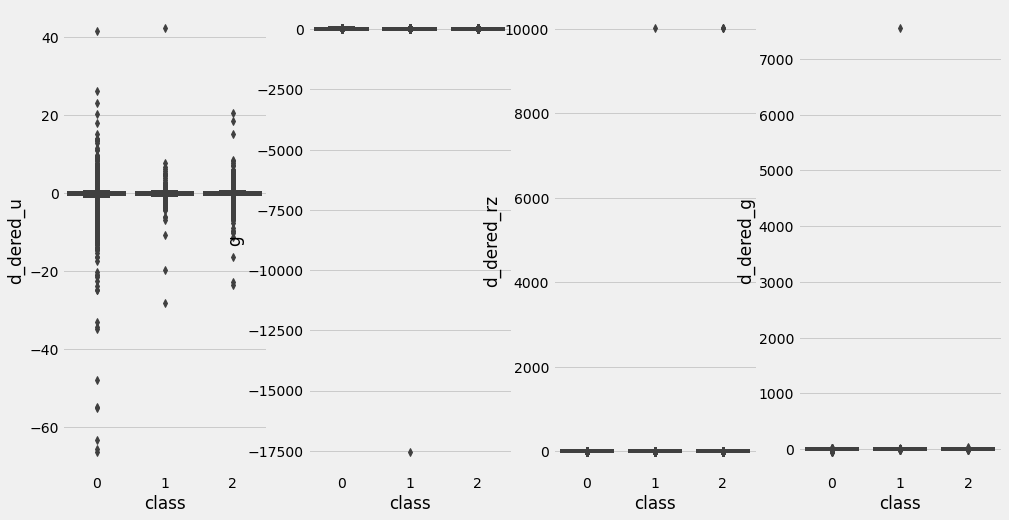

In [16]:
f , axes = plt.subplots(ncols = 4, figsize = (15,8))

sns.boxplot(x = 'class', y = 'redshift', data= train, ax= axes[0])
axes[0].set_title('class vs redshift')
sns.boxplot(x = 'class', y = 'u', data= train, ax= axes[1])
axes[1].set_title('class vs u')
sns.boxplot(x = 'class', y = 'dered_u', data= train, ax= axes[2])
axes[2].set_title('class vs dered_u')
sns.boxplot(x = 'class', y = 'r', data= train, ax= axes[3])
axes[3].set_title('class vs r')

p, axes1 = plt.subplots(ncols = 4, figsize = (15,8))
sns.boxplot(x = 'class', y = 'z', data= train, ax= axes1[0])
axes1[0].set_title('class vs z')
sns.boxplot(x = 'class', y = 'i', data= train, ax= axes1[1])
axes1[1].set_title('class vs i')
sns.boxplot(x = 'class', y = 'dered_r', data= train, ax= axes1[2])
axes1[2].set_title('class vs dered_r')
sns.boxplot(x = 'class', y = 'r', data= train, ax= axes1[3])
axes1[3].set_title('class vs r')

k, axes2 = plt.subplots(ncols = 4, figsize = (15,8))
sns.boxplot(x = 'class', y = 'd_dered_u', data= train, ax= axes2[0])
axes1[0].set_title('class vs d_dered_u')
sns.boxplot(x = 'class', y = 'g', data= train, ax= axes2[1])
axes1[1].set_title('class vs g')
sns.boxplot(x = 'class', y = 'd_dered_rz', data= train, ax= axes2[2])
axes1[2].set_title('class vs d_dered_rz')
sns.boxplot(x = 'class', y = 'd_dered_g', data= train, ax= axes2[3])
axes1[3].set_title('class vs d_dered_g')


<h3> Column 설정하기 </h3> 

In [17]:
target_col = 'class'
pred_col = 'pred'
num_cols = [x for x in train.columns if train[x].dtype in [np.int64, np.float64] and x != target_col]
print(num_cols)

['id', 'u', 'g', 'r', 'i', 'z', 'redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'airmass_u', 'nObserve_log', 'nDetect_log', 'd_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_ig', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz', 'd_obs_det']


cols_to_use 설정하기

In [50]:
num_col = [x for x in train.columns if train[x].dtype in [np.int64, np.float64] and x != target_col and x != 'id']
cols_to_use = ['u', 'g', 'r', 'i', 'z','redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'airmass_u', 'nObserve_log',
 'nDetect_log', 'd_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_ig', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz',
 'd_obs_det']
cols_to_use_small  = ['redshift','dered_u','r','dered_r','u','nObserve','nDetect']
#이 중 정규화를 했으면 좋겠는 열은 g, z, dered_z
#이외로 train에서는 i,dered_g, dered_i에서 Outlier가 있고
# test 에서는 g,z,dered_z
# Redshift의 경우 제일 영향이 많은 Column이므로 섣부른 정규화는 조심히 수행하자
cols_to_scale = ['g','z','dered_z']
num_col


['u',
 'g',
 'r',
 'i',
 'z',
 'redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'airmass_u',
 'nObserve_log',
 'nDetect_log',
 'd_dered_u',
 'd_dered_g',
 'd_dered_r',
 'd_dered_i',
 'd_dered_z',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',
 'd_obs_det']

설정한 Column 시각화 해보기

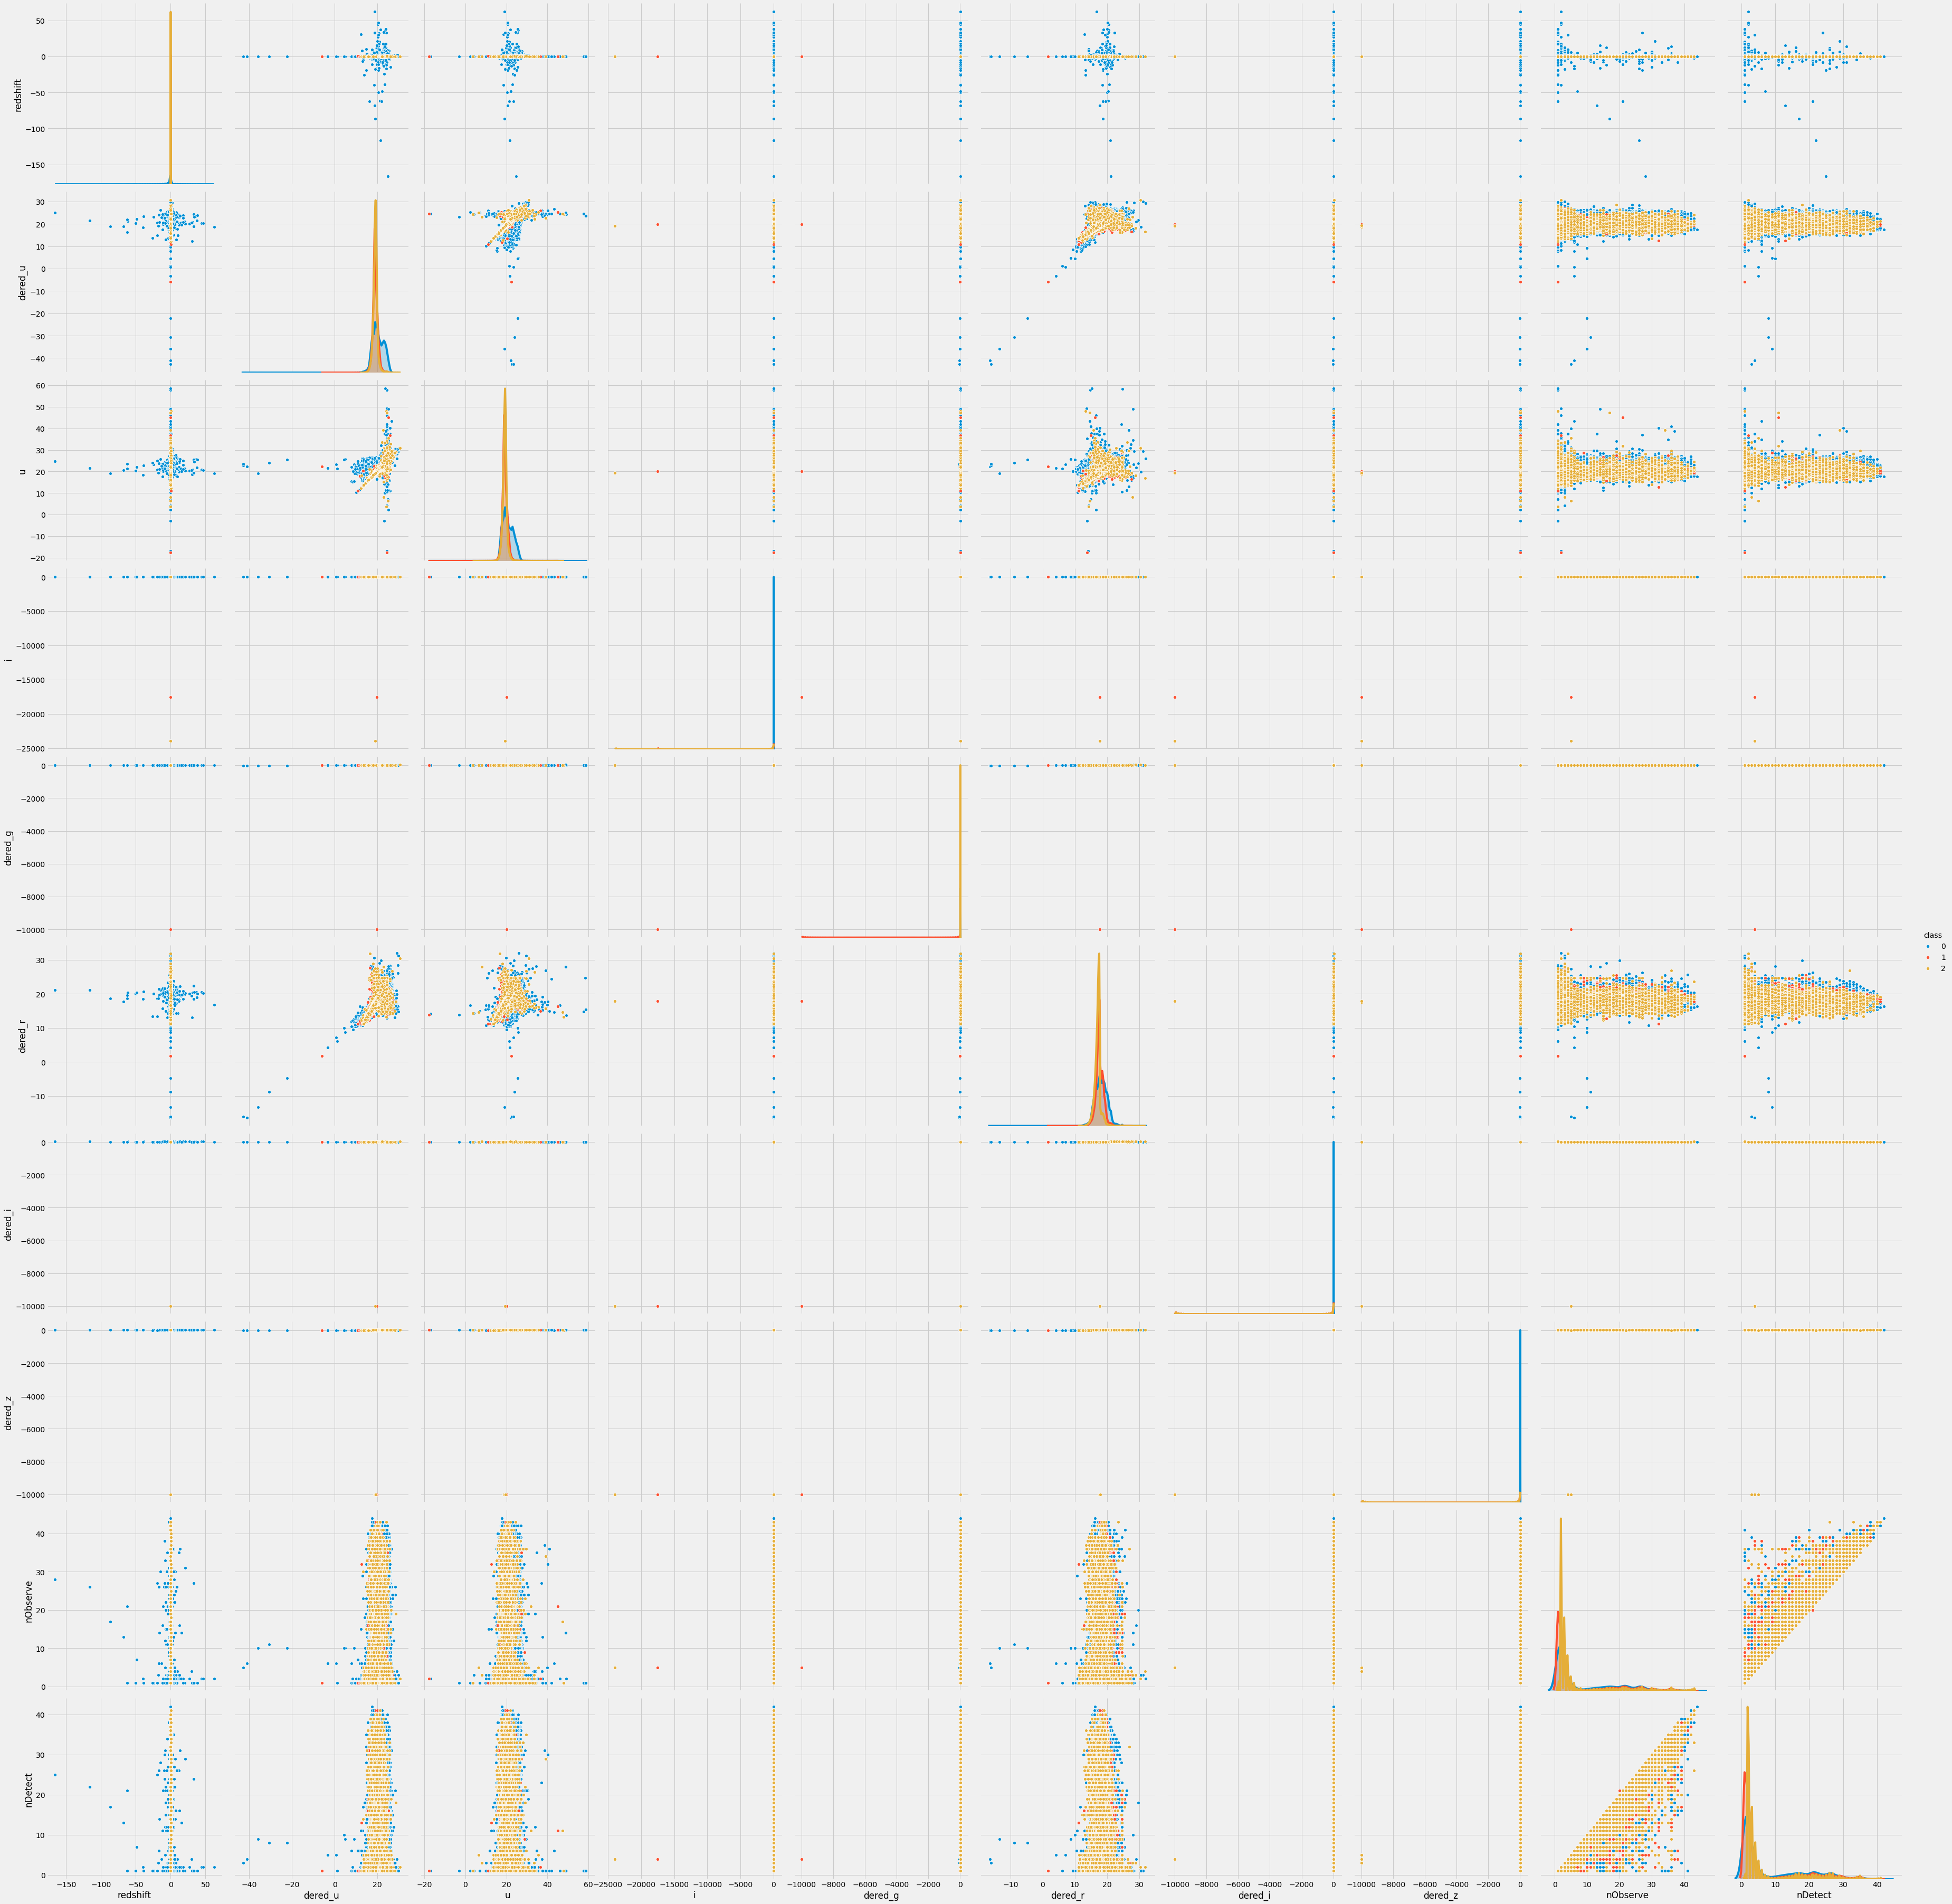

In [201]:
sns.pairplot(train, vars=cols_to_use, hue='class', size=5)

<h4> Class 0, 1만 분류 해보기 </h4>

In [20]:
class01 = train[train['class'] != 0]


<h5 style= 'color:green'>/* 여기부터 

In [70]:
from sklearn.preprocessing import StandardScaler

In [71]:
stscaler = StandardScaler()
stscaler.fit(class01)

StandardScaler()

In [79]:
class01_scaled = stscaler.transform(class01)

In [85]:
class01_scaled = pd.DataFrame(data=class01_scaled, columns = num_cols+ ['class'])

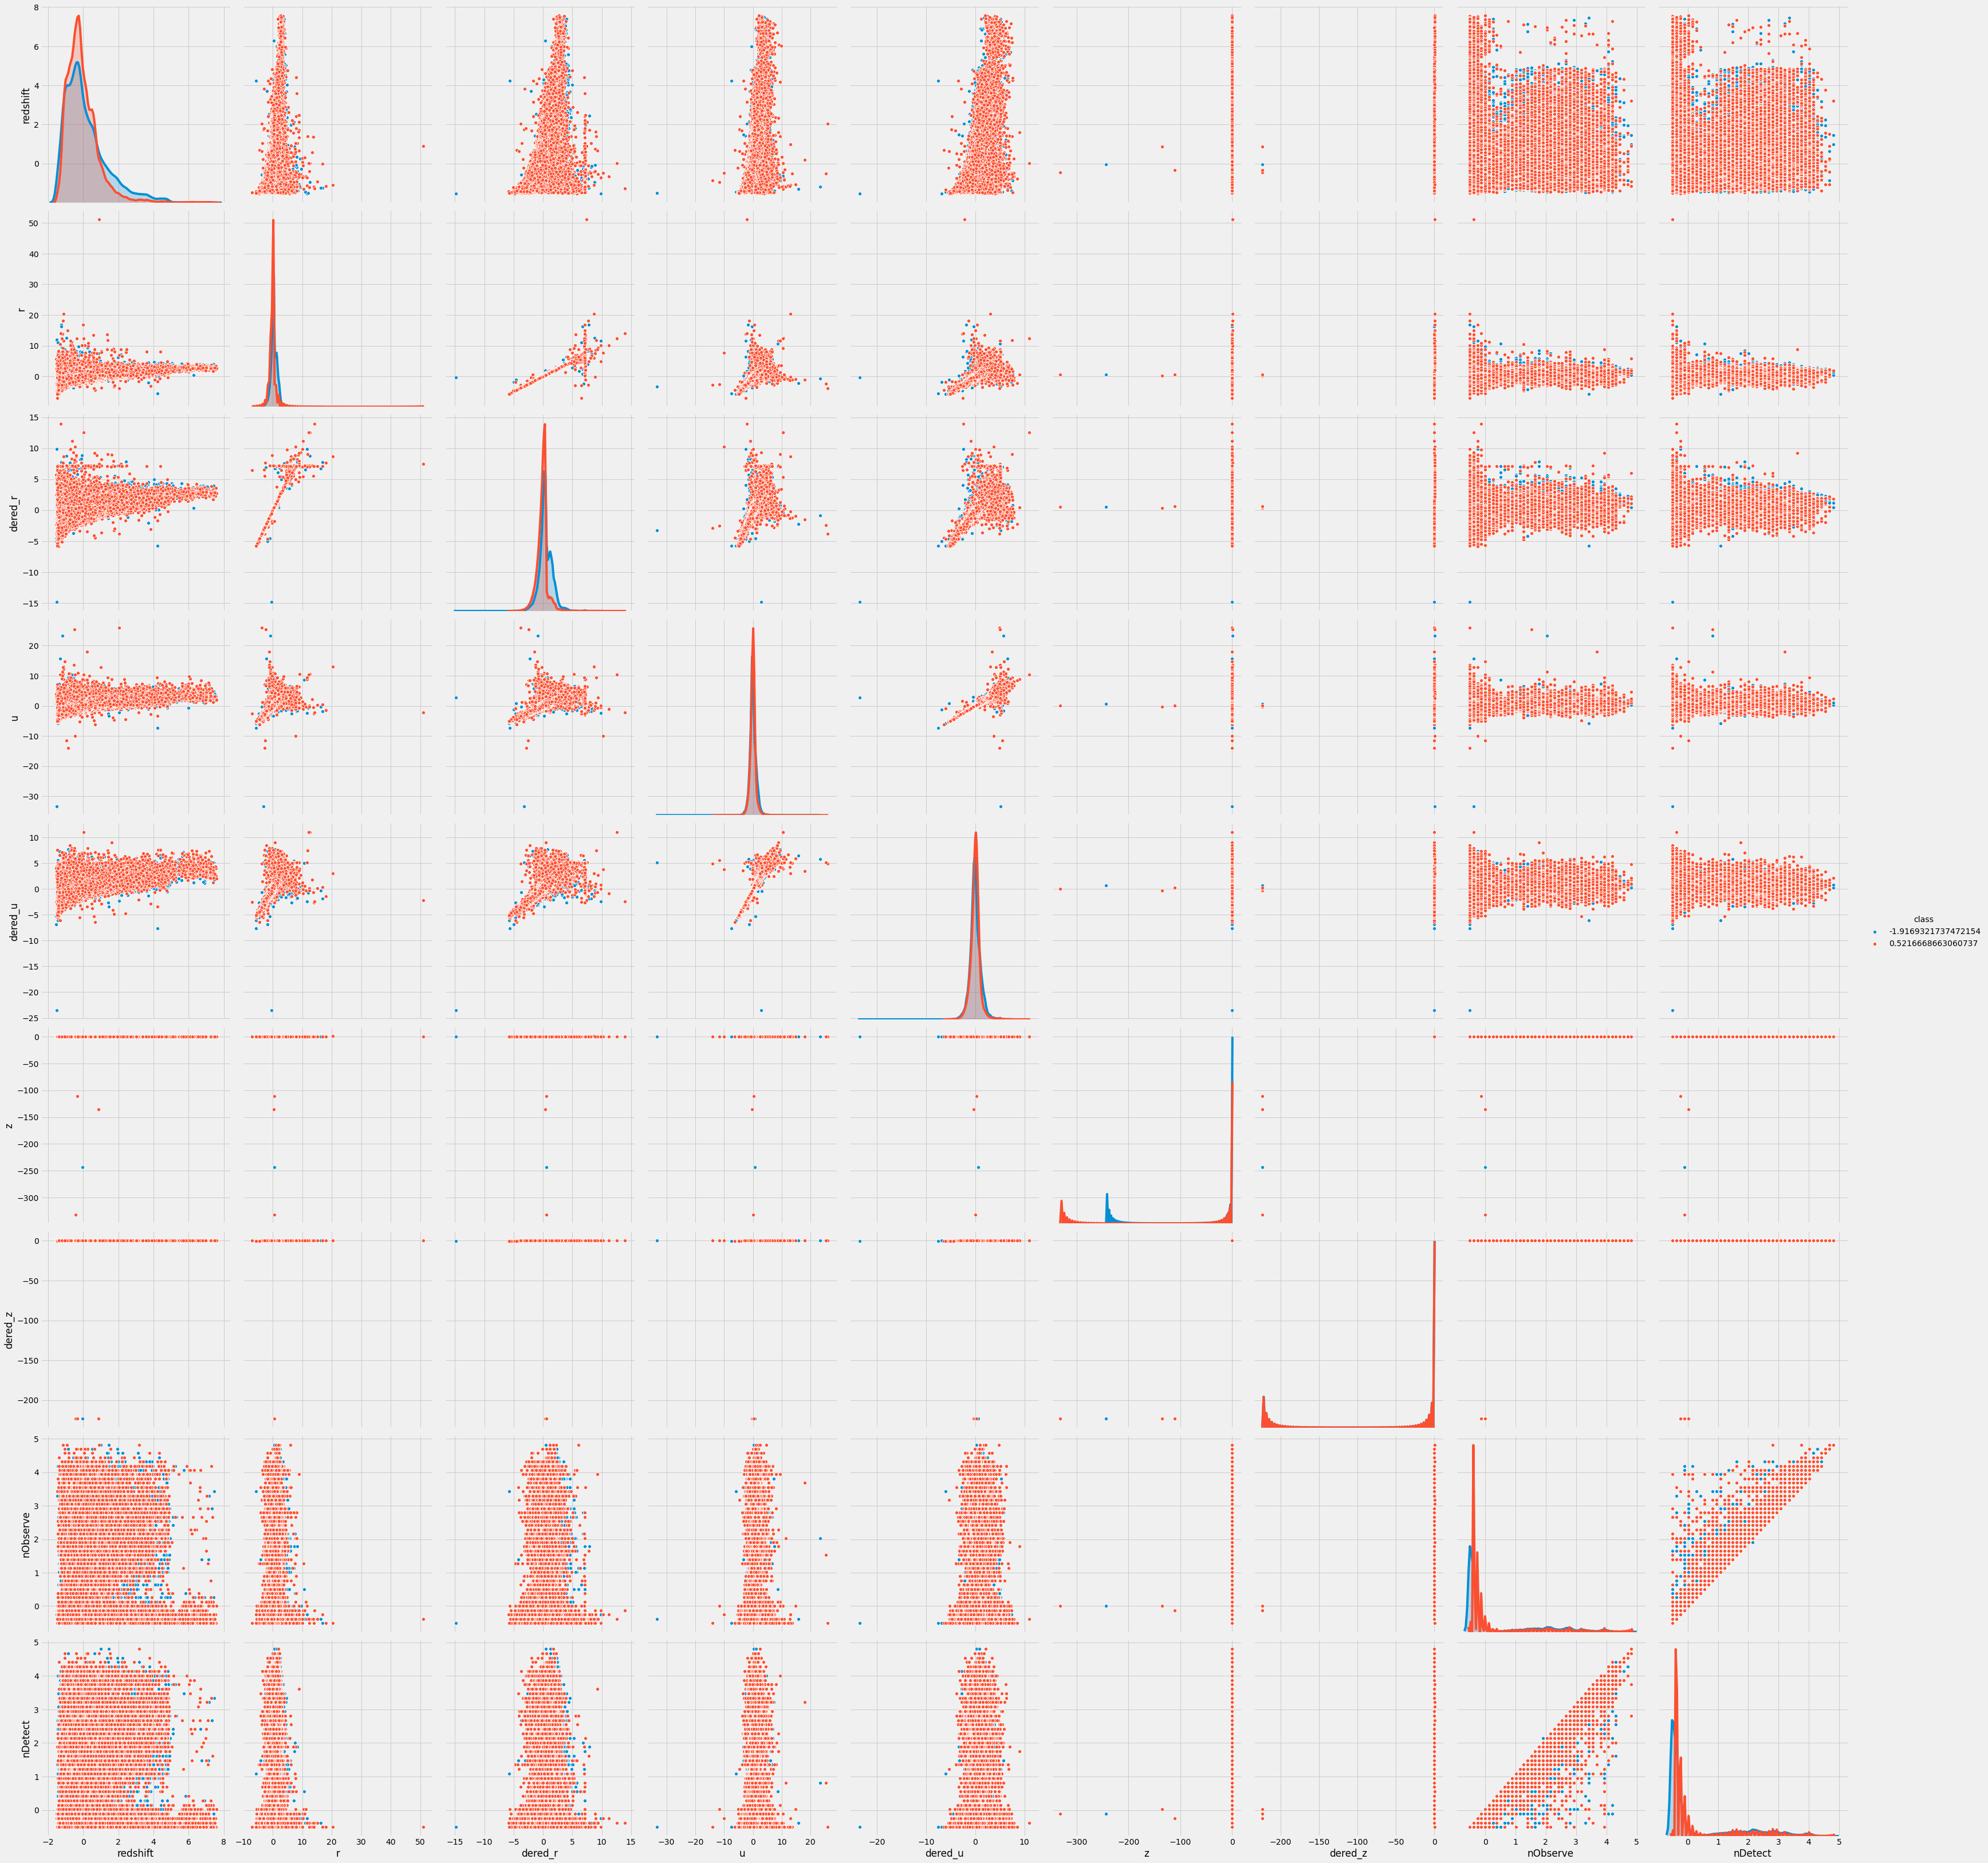

In [94]:
sns.pairplot(class01_scaled, vars=['redshift','r','dered_r','u','dered_u','z','dered_z','nObserve','nDetect'], hue = 'class', size=5)

<h5 style = 'color:green'>여기까진 무시하세요, 스케일링인데 아직 제대로 못해봄 */

<h5>SMALL Classification between class 1, class2

<h5 style='color : green'>//class 1과 2만 비교

In [21]:
#Normal
X01 = class01[cols_to_use]
y01 = class01['class']

seed = 8
test_size = 0.15
#15%는 테스트용, 85%는 학습용
X_train0, X_test0, y_train0, y_test0 = train_test_split(X01,y01, test_size = test_size , random_state = seed)
print(X_train0.shape,X_test0.shape)

(170003, 19) (30001, 19)


In [23]:
from xgboost import XGBClassifier
small_model = XGBClassifier(
                         max_depth = 11,
                         nthread = 8,
                         objective = 'binary:logistic',
                        min_child_wieght = 3,
                         n_estimators =400,
                         learning_rate = 0.15,
                        )
evals = [(X_test0, y_test0)]
#my_model = XGBRegressor(params = params, num_boost_round = nums_round,learning_rate = 0.2)
result= small_model.fit(X_train0, y_train0, early_stopping_rounds=20, eval_set=evals, verbose = True)

[13:59:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_wieght } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.13106
Will train until validation_0-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.12176
[2]	validation_0-error:0.11880
[3]	validation_0-error:0.11610
[4]	validation_0-error:0.11546
[5]	validation_0-error:0.11293
[6]	validation_0-error:0.11240
[7]	validation_0-error:0.11123
[8]	validation_0-error:0.11000
[9]	validation_0-error:0.10963
[10]	validation_0-error:0.10930
[11]	validation_0-error:0.10836
[12]	validation_0-error:0.10773
[13]	validation_0-error:0.10800
[14]	validation_0-error:0.10723
[15]	validation_0-error:0.10746
[16]	validation_0-error:0.10713
[17]	v

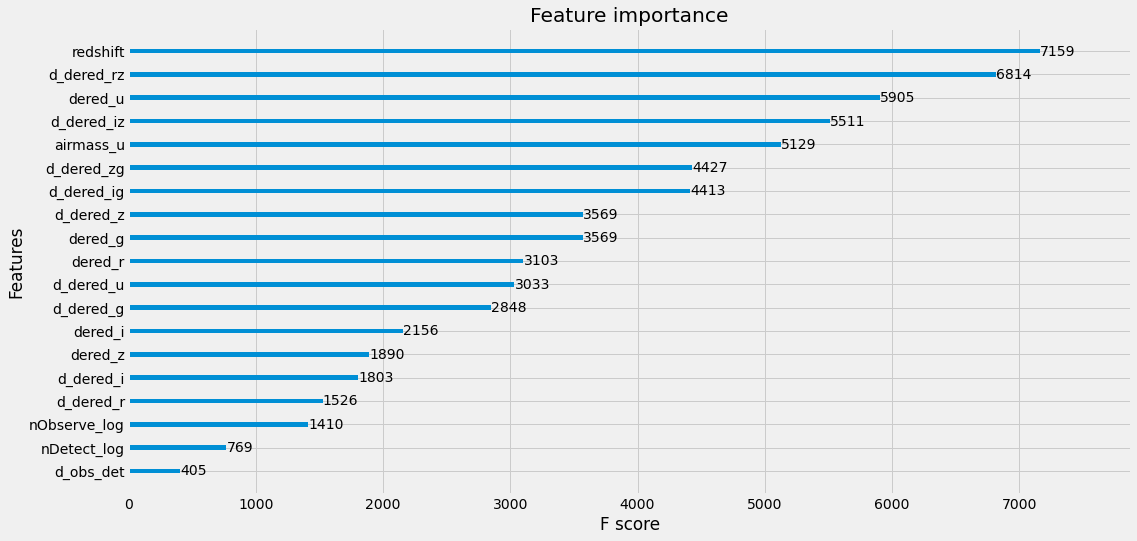

In [24]:
plot_importance(small_model)

In [25]:
y_pred0 = small_model.predict(X_test0)
y_pred0
predictions0 = [round(value) for value in y_pred0]

In [26]:
predictions0

[2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [27]:
accuracy = accuracy_score(y_test0, predictions0)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.01%


해보면 알겠지만, Class 1, 2를 구분하는게 전체 정확도에 큰 영향을 줌

cols_to_scale 분포 보기

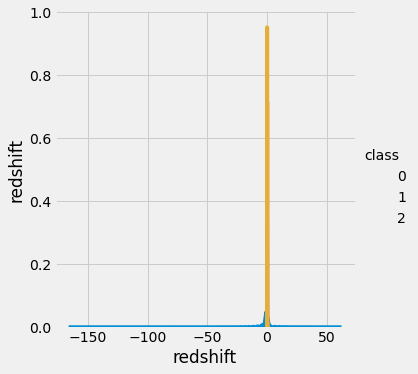

In [21]:
sns.pairplot(train, vars=['redshift'], hue='class', size=5)

<h5 style="color:green">/* 처음 할때는 여기 무시하세요 

<h1> 데이터 정규화 및 Outlier 처리</h1>

cols_to_scale에 정규화를 적용한 cols_scaled와 train_scaled를 생성해 보기

일반적인 정규화 <br>
    1. StandardScaler
    2. MinMaxScaler 최대 최소 스케일링
Outlier가 있을 때
    1. Z-score
    2. Tukey_fences
    3. Robust Scaler
     

<h4>> 내가 접근 해볼 것</h4>
1. Outlier를 아예 Train 에서 제거하고, 모델 학습을 시킨다     --> Model0 <br>
2. Outlier가 포함된 Train 에서 Scaler모델을 적용, 학습시킨다  --> Model1 <br>
3. Outlier를 아예 제거, 정규화(StandardScaler)를 적용해 본다  --> Model2

<h5> 1. Model0 </h5>

In [28]:
train[cols_to_use].describe()

,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
count,3.2000e+05,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000
mean,5.8308e-02,19.6289,18.2271,17.6154,17.1523,16.8693,1.1758,1.4861,1.4702,-0.2236,-0.1498,-0.1203,-0.0219,-0.0059,-1.0747,-1.3578,0.7462,0.2831,0.1939
std,5.7546e-01,1.9236,17.7866,1.4730,25.0758,35.4365,0.1163,0.9061,0.8959,0.6967,13.3675,0.3630,28.0581,28.2757,17.7284,30.6874,35.4207,25.0444,1.0243
min,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0001,0.6931,0.6931,-66.3661,-51.2796,-46.9576,-26.3505,-1968.6898,-10017.1270,-10017.2590,-17.7428,-16.6637,-1.0000
25%,3.5580e-05,18.5636,17.3484,16.7871,16.4530,16.2341,1.0882,0.6931,0.6931,-0.2342,-0.1649,-0.1136,-0.0847,-0.0700,-1.2330,-1.5263,0.3072,0.0844,0.0000
50%,4.7129e-02,19.2646,18.0224,17.4434,17.0874,16.8694,1.1793,1.0986,1.0986,-0.1342,-0.1014,-0.0701,-0.0523,-0.0405,-0.9160,-1.1169,0.5338,0.2009,0.0000
75%,9.4597e-02,20.1976,18.8884,18.2911,17.9070,17.6557,1.2275,1.7918,1.7918,-0.0706,-0.0632,-0.0439,-0.0325,-0.0207,-0.6014,-0.6951,0.7146,0.2965,0.0000
max,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,2.0508,3.8067,3.7612,42.2511,7556.3656,16.9807,13956.8178,13956.8178,21.8604,27.7746,10016.8755,10016.5565,40.0000


In [29]:
ids = train
show = ids[(ids['dered_g'] <-1000) | (ids['dered_i'] < -1000) | (ids['dered_z'] <-1000) & (ids['class'] == 0) ]
train_model0 = ids[(ids['dered_g'] >-1000) & (ids['dered_i'] > -1000) & (ids['dered_z'] >-1000)]
train_model0

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,class,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
0,0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,1.1898,0,2.9444,2.9444,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,0
1,1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1.2533,1,0.6931,0.6931,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,0
2,2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0225,0,1.0986,1.0986,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,0
3,3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.2054,0,1.6094,1.3863,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,1
4,4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,1.1939,0,2.6391,2.5649,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319995,319995,18.3656,17.2409,16.7739,16.4850,16.3404,5.1988e-02,18.1328,17.0406,16.6374,16.3861,16.2874,1.0930,2,1.0986,1.0986,-0.2328,-0.2002,-0.1365,-0.0989,-0.0530,-0.6546,-0.7532,0.3500,0.0986,0
319996,319996,18.6856,17.6658,17.1904,16.8169,16.6367,8.7261e-02,18.5207,17.5131,17.0871,16.7436,16.6017,1.0517,1,1.0986,1.0986,-0.1649,-0.1527,-0.1033,-0.0732,-0.0350,-0.7695,-0.9114,0.4854,0.1419,0
319997,319997,21.1890,18.4234,17.2956,16.9011,16.6841,-1.0148e-05,20.9890,18.3076,17.2152,16.8403,16.6355,1.1933,0,3.4657,3.4340,-0.2000,-0.1158,-0.0804,-0.0608,-0.0486,-1.4673,-1.6721,0.5796,0.2048,1
319998,319998,18.8472,17.3186,16.5057,16.1806,15.9116,-4.5209e-05,16.3900,15.4058,15.1823,15.1969,15.1793,1.1725,0,0.6931,0.6931,-2.4572,-1.9128,-1.3234,-0.9836,-0.7323,-0.2089,-0.2264,0.0029,0.0176,0


In [30]:
train_model0.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,class,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
count,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,3.2000e+05,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000
mean,159999.9526,19.8524,18.4318,17.7358,17.3041,17.0608,5.8307e-02,19.6289,18.2584,17.6154,17.2149,16.9945,1.1758,1.1163,1.4861,1.4702,-0.2236,-0.1734,-0.1203,-0.0891,-0.0663,-1.0434,-1.2639,0.6210,0.2205,0.1939
std,92376.5460,1.9456,1.6612,1.4663,1.3226,1.3370,5.7546e-01,1.9236,1.6681,1.4730,1.3294,1.3263,0.1163,0.9235,0.9061,0.8960,0.6967,0.4989,0.3630,0.2960,0.3156,0.8898,1.1140,0.7714,0.4587,1.0243
min,0.0000,-17.6875,-12.4441,7.7314,-23.9024,-9.2548,-1.6605e+02,-42.8375,-30.3208,-16.3802,-8.9412,-3.7059,1.0001,0.0000,0.6931,0.6931,-66.3661,-51.2796,-46.9576,-26.3505,-30.5841,-15.0278,-17.2340,-17.7428,-16.6637,-1.0000
25%,79999.7500,18.7241,17.4749,16.8772,16.5239,16.2889,3.5578e-05,18.5636,17.3484,16.7871,16.4531,16.2341,1.0882,0.0000,0.6931,0.6931,-0.2342,-0.1649,-0.1136,-0.0847,-0.0700,-1.2330,-1.5262,0.3072,0.0844,0.0000
50%,160000.5000,19.4194,18.1405,17.5258,17.1497,16.9176,4.7128e-02,19.2646,18.0224,17.4434,17.0874,16.8694,1.1793,1.0000,1.0986,1.0986,-0.1342,-0.1014,-0.0701,-0.0523,-0.0405,-0.9160,-1.1169,0.5338,0.2009,0.0000
75%,240000.2500,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8885,18.2911,17.9070,17.6557,1.2275,2.0000,1.7918,1.7918,-0.0706,-0.0632,-0.0439,-0.0325,-0.0207,-0.6014,-0.6951,0.7146,0.2965,0.0000
max,319999.0000,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,2.0508,2.0000,3.8067,3.7612,42.2511,37.5039,16.9807,48.3583,33.8940,21.8604,27.7746,16.3026,16.4438,40.0000


<h4> 2. Model1 </h4>: Outlier + RobustScaler

In [258]:
train.feature_names

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [262]:
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
print(robustScaler.fit(train))
train_robust_scaled = robustScaler.transform(train)
train.info()
train_robust_scaled
#transform시 스케일 변환된 데이터 세트가 NumPy ndarray로 변환, 이를 DF로 변환
#train_model1 = pd.DataFrame(data =train_robust_scaled, columns =num_cols)
#train_model1.describe()

RobustScaler()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320000 entries, 0 to 319999
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         320000 non-null  int64  
 1   u          320000 non-null  float64
 2   g          320000 non-null  float64
 3   r          320000 non-null  float64
 4   i          320000 non-null  float64
 5   z          320000 non-null  float64
 6   redshift   320000 non-null  float64
 7   dered_u    320000 non-null  float64
 8   dered_g    320000 non-null  float64
 9   dered_r    320000 non-null  float64
 10  dered_i    320000 non-null  float64
 11  dered_z    320000 non-null  float64
 12  nObserve   320000 non-null  int64  
 13  nDetect    320000 non-null  int64  
 14  airmass_u  320000 non-null  float64
 15  airmass_g  320000 non-null  float64
 16  airmass_r  320000 non-null  float64
 17  airmass_i  320000 non-null  float64
 18  airmass_z  320000 non-null  float64
 19  class   

array([[-1.        ,  2.25096502,  1.37409575, ...,  0.07097471,
         0.0787459 , -0.5       ],
       [-0.99999375, -2.55704925, -2.55177875, ...,  0.50946359,
         0.55056407,  0.        ],
       [-0.9999875 , -1.54165324, -1.44845966, ..., -1.1214217 ,
        -1.12678213, -0.5       ],
       ...,
       [ 0.9999875 ,  1.03606177,  0.17695395, ...,  0.09596435,
         0.10385821, -0.5       ],
       [ 0.99999375, -0.33505355, -0.51424183, ..., -0.04925015,
        -0.04918459, -0.5       ],
       [ 1.        ,  0.25820525,  0.42503254, ..., -0.86684462,
        -0.88584986, -0.5       ]])

In [31]:
X_m0 = train_model0[cols_to_use]
X_m0.describe()

,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
count,3.2000e+05,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000,319996.0000
mean,5.8307e-02,19.6289,18.2584,17.6154,17.2149,16.9945,1.1758,1.4861,1.4702,-0.2236,-0.1734,-0.1203,-0.0891,-0.0663,-1.0434,-1.2639,0.6210,0.2205,0.1939
std,5.7546e-01,1.9236,1.6681,1.4730,1.3294,1.3263,0.1163,0.9061,0.8960,0.6967,0.4989,0.3630,0.2960,0.3156,0.8898,1.1140,0.7714,0.4587,1.0243
min,-1.6605e+02,-42.8375,-30.3208,-16.3802,-8.9412,-3.7059,1.0001,0.6931,0.6931,-66.3661,-51.2796,-46.9576,-26.3505,-30.5841,-15.0278,-17.2340,-17.7428,-16.6637,-1.0000
25%,3.5578e-05,18.5636,17.3484,16.7871,16.4531,16.2341,1.0882,0.6931,0.6931,-0.2342,-0.1649,-0.1136,-0.0847,-0.0700,-1.2330,-1.5262,0.3072,0.0844,0.0000
50%,4.7128e-02,19.2646,18.0224,17.4434,17.0874,16.8694,1.1793,1.0986,1.0986,-0.1342,-0.1014,-0.0701,-0.0523,-0.0405,-0.9160,-1.1169,0.5338,0.2009,0.0000
75%,9.4597e-02,20.1976,18.8885,18.2911,17.9070,17.6557,1.2275,1.7918,1.7918,-0.0706,-0.0632,-0.0439,-0.0325,-0.0207,-0.6014,-0.6951,0.7146,0.2965,0.0000
max,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,2.0508,3.8067,3.7612,42.2511,37.5039,16.9807,48.3583,33.8940,21.8604,27.7746,16.3026,16.4438,40.0000


In [ ]:
X_m1 = train_model1[cols_to_use]
X_m2 = train_model2[cols_to_use]

In [35]:
y_m0 = train_model0['class']
y_m0

0         0
1         1
2         0
3         0
4         0
         ..
319995    2
319996    1
319997    0
319998    0
319999    0
Name: class, Length: 319996, dtype: int64

<h4> Xgboost </h4>

<h4> Train Split </h4>

In [51]:
#Normal
X = train[cols_to_use]
y = train['class']

seed = 8
test_size = 0.15
#15%는 테스트용, 85%는 학습용
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size , random_state = seed)
print(X_train.shape,X_test.shape)

(272000, 24) (48000, 24)


<h5 style = "color:green">/*

In [36]:
#Model 0
seed = 8
test_size = 0.15
#10%는 테스트용, 90%는 학습용
X_train, X_test, y_train, y_test = train_test_split(X_m0,y_m0, test_size = test_size , random_state = seed)
print(X_train.shape,X_test.shape)

(271996, 19) (48000, 19)


In [134]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

<h5 style="color:green">*/

In [63]:
testX = test[cols_to_use]
testX

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,nObserve_log,nDetect_log,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
0,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1.1563,0.6931,0.6931,-0.0681,-0.0622,-0.0424,-0.0306,-0.0176,-0.8711,-1.0462,0.5221,0.1751,0
1,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,1.0076,1.0986,1.0986,-3.6706,-2.8607,-1.9790,-1.4705,-1.0935,0.2062,0.3274,-0.2470,-0.1212,0
2,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1.3809,0.6931,0.6931,-0.1977,-0.1077,-0.0761,-0.0599,-0.0664,-1.0230,-1.2037,0.5771,0.1808,0
3,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1.1408,0.6931,0.6931,-0.1045,-0.0834,-0.0572,-0.0418,-0.0288,-0.3036,-0.3068,0.0802,0.0032,0
4,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,1.1110,1.0986,1.0986,-0.0780,-0.0852,-0.0572,-0.0407,-0.0187,-0.8480,-1.0361,0.5129,0.1881,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,19.6734,18.6617,18.2708,18.1225,18.0627,-3.1726e-04,19.3361,18.3933,18.0860,17.9861,17.9670,1.1858,2.8904,2.8904,-0.3372,-0.2684,-0.1848,-0.1364,-0.0957,-0.4072,-0.4263,0.1190,0.0191,0
79996,21.5229,20.7283,20.6087,21.0049,20.8458,6.5455e-02,21.3993,20.6399,20.5451,20.9507,20.7827,1.2850,2.1972,1.6094,-0.1235,-0.0884,-0.0636,-0.0542,-0.0631,0.3108,0.1428,-0.2376,0.1680,4
79997,19.3991,18.2411,18.1605,18.1978,18.2018,-8.4180e-04,18.9136,17.8753,17.9047,18.0043,18.0400,1.1885,0.6931,0.6931,-0.4855,-0.3657,-0.2558,-0.1935,-0.1618,0.1289,0.1647,-0.1353,-0.0357,0
79998,18.8997,17.6009,17.1329,16.8223,16.5946,4.2817e-02,18.7715,17.4880,17.0557,16.7660,16.5585,1.1804,2.8904,2.8904,-0.1282,-0.1129,-0.0772,-0.0564,-0.0361,-0.7220,-0.9295,0.4972,0.2075,0


In [176]:
#최적 파라미터 찾는 부분, 10시간 걸리니까 건들지 말것
from sklearn.model_selection import GridSearchCV
# n_estimators = 100? 500? 1000?
xgb_clf = XGBClassifier(n_estimators = 500, nthread = 12)
params = {
          'learning_rate' : [0.1,0.12],
         'objective':['multi:softmax'],
         }
gridcv = GridSearchCV(xgb_clf, param_grid = params, cv =3 )
gridcv.fit(X_train,y_train,max_depth = 9, min_child_weight=3, early_stopping_rounds = 30, eval_set=[(X_test,y_test)])

print('GridSearchCV 최적 파라미터 : ', gridcv.best_params_)
xgb_roc_score = roc_auc_score(y_test,gridcv.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC : {0.4f}'.format(xgb_roc_score))


TypeError: fit() got an unexpected keyword argument 'max_depth'

<h4>기다리던 학습</h4>

In [52]:
from xgboost import XGBClassifier
my_model = XGBClassifier(
                         max_depth = 11,
                         nthread = 8,
                         objective = 'multi:softmax',
                         n_estimators =1000,
                        min_child_weight =3,
                        subsample =.8,
                         learning_rate = 0.15,
                        )
evals = [(X_test, y_test)]
#my_model = XGBRegressor(params = params, num_boost_round = nums_round,learning_rate = 0.2)
result= my_model.fit(X_train,y_train, early_stopping_rounds=30, eval_set=evals, verbose = True)

[0]	validation_0-merror:0.08085
Will train until validation_0-merror hasn't improved in 30 rounds.
[1]	validation_0-merror:0.07848
[2]	validation_0-merror:0.07681
[3]	validation_0-merror:0.07567
[4]	validation_0-merror:0.07465
[5]	validation_0-merror:0.07410
[6]	validation_0-merror:0.07365
[7]	validation_0-merror:0.07292
[8]	validation_0-merror:0.07227
[9]	validation_0-merror:0.07123
[10]	validation_0-merror:0.07046
[11]	validation_0-merror:0.07023
[12]	validation_0-merror:0.07002
[13]	validation_0-merror:0.06977
[14]	validation_0-merror:0.06952
[15]	validation_0-merror:0.06929
[16]	validation_0-merror:0.06894
[17]	validation_0-merror:0.06863
[18]	validation_0-merror:0.06831
[19]	validation_0-merror:0.06813
[20]	validation_0-merror:0.06790
[21]	validation_0-merror:0.06783
[22]	validation_0-merror:0.06800
[23]	validation_0-merror:0.06760
[24]	validation_0-merror:0.06731
[25]	validation_0-merror:0.06746
[26]	validation_0-merror:0.06727
[27]	validation_0-merror:0.06679
[28]	validation_0-m

In [53]:
y_pred = my_model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [54]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.5f%%" % (accuracy * 100.0))

Accuracy: 93.54167%


<h5 style = "color:green">/*교차검증Cross Validation, 건드리지 않는게 좋음</h5>

In [38]:
cv = KFold(5, shuffle=True, random_state=0)

In [39]:
cross_val_score(my_model, X, y, scoring='accuracy', cv=cv)

array([0.93351562, 0.93345312, 0.93279687, 0.9323125 , 0.93279687])

<h5 style = "color:green">*/

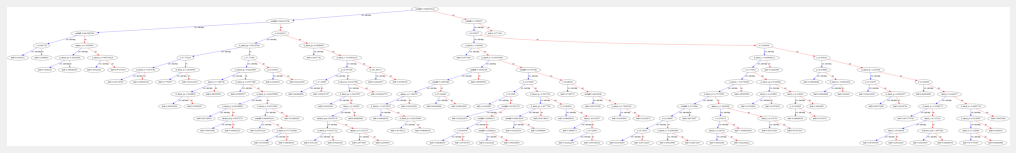

In [55]:
from xgboost import plot_tree
plot_tree(my_model)

In [56]:
import graphviz
dot_data = export_graphviz(my_model, out_file =None,
                          feature_names = cols_to_use,
                           filled = True,
                           rounded = True,
                           special_characters = True
                          )

graph = graphviz.Source(dot_data)
graph

AttributeError: 'XGBClassifier' object has no attribute 'n_features_'

In [57]:
pred_probs = my_model.predict(X_test)
pred_probs

array([2, 2, 2, ..., 0, 2, 0], dtype=int64)

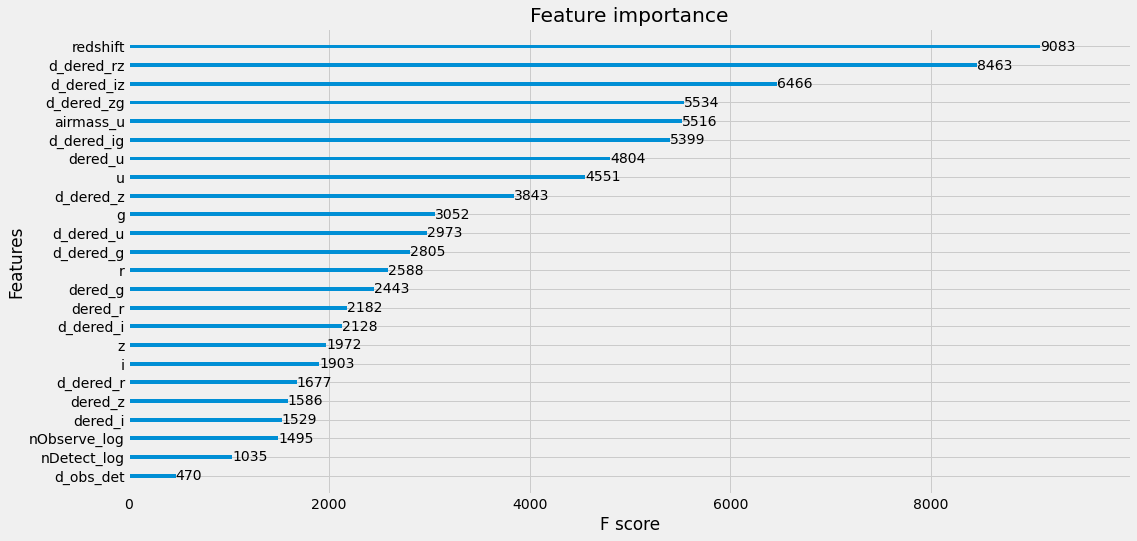

In [58]:
plot_importance(my_model)

In [59]:
y_pred = my_model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [60]:
mean_squared_error(y_test, y_pred)

0.06645833333333333

In [61]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.5f%%" % (accuracy * 100.0))

Accuracy: 93.54167%


In [64]:
Y_pred = my_model.predict(testX)
predictions = [round(value) for value in Y_pred]
predictions

[2,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 0,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 1,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 2,


In [ ]:
predictions = [ 1 if x >0.5 and x < 1.5 else ( 0 if x >-0.5 and x< 0.5 else 2) for x in predictions ]

In [65]:
# final result
submission['class'] = predictions
submission.to_csv("8515XGB_release_9354.csv",index=False, encoding='utf-8-sig')